**Deep Learning Sentiment Analysis Project - David Blankenship**

The Following Code was ran locally on my PC, the Cell for Google Colab is for the case that my model needs to be retrained to verify it.

**Connecting to Google Drive**
Only Run if Google Colab is used

In [ ]:
# Mount your Google Drive to this notebook
from google.colab import drive
drive.mount('/content/drive')

# Change the directory to your own working directory. (A "directory" is the same thing as a "folder".)
# Any files under your working directory are available to your code.
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Installing all the Libraries Used

**Be sure to change the file path to the folder that you are using for the code to function.**

In [2]:
# Uncomment if ran on Colab
#! pip install datasets 
#! pip install evaluate
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset
import evaluate
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torchinfo import summary
from transformers import get_scheduler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

path = r'D:\Grad School - VT\Coursework\9th Semester (S25, CPE)\Deep Learning (Stats)\Project'

cuda


**Preprocessing Dataset**

Only Requires original dataset to be present in the Google Drive folder.  
The code takes care of splitting it into train/dev/test sets and setting to expected formats.

Test Set Size = 40000 / Dev Set Size = 5000 / Test Set Size = 5000


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

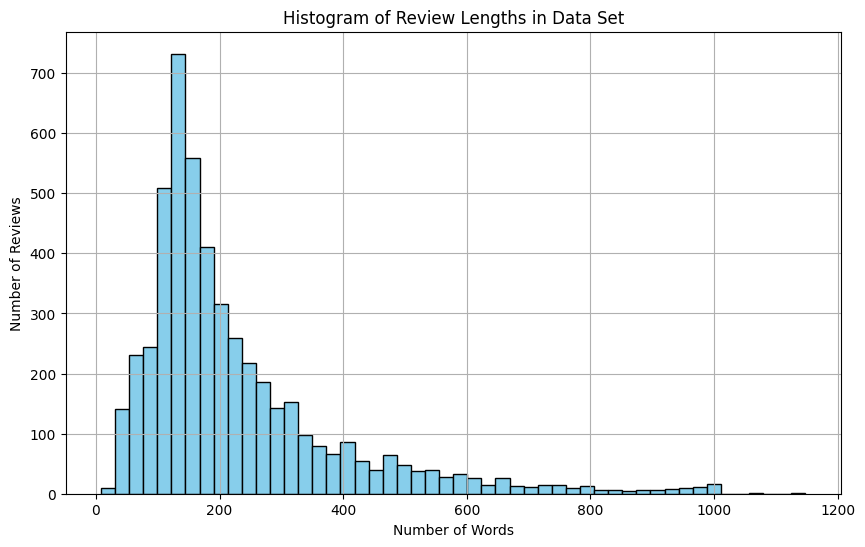

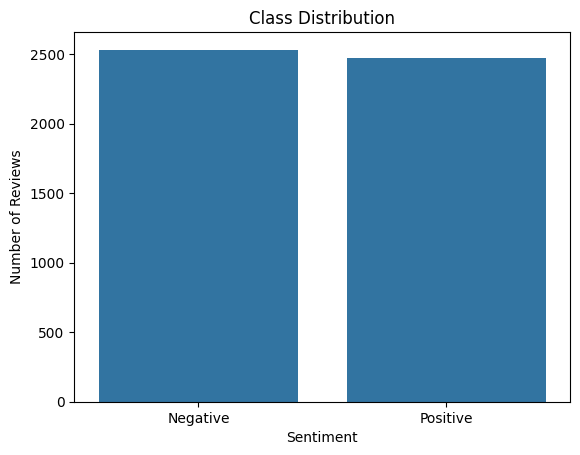

In [ ]:
# Loading in Dataset, must include your own path to recreate
df = pd.read_csv(os.path.join(path, 'IMDB Dataset.csv'))

# Mapping sentiment to 0 and 1
df['sentiment'] = df['sentiment'].map({'positive': 0, 'negative': 1}) 

# Number of samples per dataset split
train_num = 40000
dev_num = 5000
test_num = 5000

rand_seed = 24060

# Splitting dataset into train/dev/test sets
train_dataset = df.sample(frac=train_num/len(df), random_state=rand_seed)
df = df.drop(train_dataset.index)
dev_dataset = df.sample(frac=dev_num/len(df), random_state=rand_seed)
df = df.drop(dev_dataset.index)
test_dataset = df.sample(frac=test_num/len(df), random_state=rand_seed)

print('Test Set Size =', len(train_dataset),'/ Dev Set Size =', len(dev_dataset),'/ Test Set Size =', len(test_dataset))

# Setting datasets as Huggingface datasets
train_dataset = Dataset.from_pandas(train_dataset, preserve_index=False)
dev_dataset = Dataset.from_pandas(dev_dataset, preserve_index=False)
test_dataset = Dataset.from_pandas(test_dataset, preserve_index=False)

# Model id and Tokenizer, DistillBERT was used for this project
model_id = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id, clean_up_tokenization_spaces=True)

# Function to tokenize
def tokenize_function(examples):
    # Tokenize the text and include the labels
    tokenized_output = tokenizer(examples["review"], padding="max_length", truncation=True)
    # Rename the 'sentiment' column to 'labels' which is expected by the Trainer
    tokenized_output['labels'] = examples['sentiment']
    return tokenized_output

# Tokenizing, removing columns and setting datasets as torch format
train_dataset = train_dataset.map(tokenize_function, batched=True)
train_dataset = train_dataset.remove_columns(["review", "sentiment"])
train_dataset.set_format("torch")

dev_dataset = dev_dataset.map(tokenize_function, batched=True)
dev_dataset = dev_dataset.remove_columns(["review", "sentiment"])
dev_dataset.set_format("torch")

test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.remove_columns(["review", "sentiment"])
test_dataset.set_format("torch")

# Making Dataset Plots
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Review Lengths in Data Set')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

DISTILBERT Model Training

In [ ]:
model_name = 'DISTILBERT_Model'

# Hyperparameters
batch_size = 8
learning_rate = 2e-5
epoch_num = 3

# Setting datasets to torch expected format
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Loading model and moving it to device
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2);
model.to(device)

# Setting optimizer to Adam
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Setting learning rate scheduler
num_steps = len(train_dataloader)*epoch_num
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_steps)

# Setting evaluation metric
metric = evaluate.load("f1")
model.eval()
loss_fn = nn.CrossEntropyLoss()

# Model Training Loop
model.train()
for epoch in range(epoch_num):

    # Setting progress bar
    pbar = tqdm(range(int(num_steps/epoch_num)))
    pbar.set_description(f"Epoch {epoch+1} Training")

    losses = []
    # Training Loop
    for batch in train_dataloader:
        pbar.update(1)

        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        outputs = model(batch['input_ids'], batch['attention_mask'])
        logits = outputs['logits']

        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    pbar = tqdm(range(int(num_steps/epoch_num)))
    pbar.set_description(f"Epoch {epoch+1} Train Score")
    
    # Acc score loop for training set
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          labels = batch['labels']
          outputs = model(batch['input_ids'], batch['attention_mask'])

        pbar.update(1)
        logits = outputs['logits']
        preds = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=preds, references=labels)

    train_acc =  metric.compute()

    pbar = tqdm(range(len(dev_dataloader)))
    pbar.set_description(f"Epoch {epoch+1} Dev Score")
    
    # Acc score loop for devlopment set
    for batch in dev_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          labels = batch['labels']
          outputs = model(batch['input_ids'], batch['attention_mask'])

        pbar.update(1)
        logits = outputs['logits']
        preds = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=preds, references=labels)

    dev_acc =  metric.compute()

    print(f"loss =", round(np.mean(losses), 8))
    print(f"Epoch {epoch+1} Train F1 Score =", round(train_acc["f1"], 5))
    print(f"Epoch {epoch+1} Dev F1 Score =", round(dev_acc["f1"], 5))

    print("---------------------------------------------------")

pbar = tqdm(range(len(test_dataloader)))
pbar.set_description(f"Epoch {epoch+1} Test Score")

# Acc score loop for test set
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      labels = batch['labels']
      outputs = model(batch['input_ids'], batch['attention_mask'])

    pbar.update(1)
    logits = outputs['logits']
    preds = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=preds, references=labels)

print("Test F1 Score =", round(metric.compute()["f1"], 5))

# Saves the model to specifiec path
model.save_pretrained(os.path.join(path, model_name), from_pt=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 0.22706855
Epoch 1 Train F1 Score = 0.96133
Epoch 1 Dev F1 Score = 0.93402
---------------------------------------------------


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 0.10875468
Epoch 2 Train F1 Score = 0.98728
Epoch 2 Dev F1 Score = 0.93588
---------------------------------------------------


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 0.04222348
Epoch 3 Train F1 Score = 0.99416
Epoch 3 Dev F1 Score = 0.93959
---------------------------------------------------


  0%|          | 0/625 [00:00<?, ?it/s]

Test F1 Score = 0.93495


DISTILBERT Evaluation and Model Summary

In [ ]:
# Loading model and evaluating
model_name = 'DISTILBERT_Model'
model_path = os.path.join(path, model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)

#Hyperparameter required for cell
batch_size = 8

# Setting datasets to expected format
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Setting lists for evaluation loop
sets = ['Train', 'Dev', 'Test']
data_sets = [train_dataloader, dev_dataloader, test_dataloader]

# Setting evaluation metric
metric = evaluate.load("f1")
model.eval()

for i in range(0,len(sets)):

    name = sets[i]
    data = data_sets[i]
    
    pbar = tqdm(range(len(data)))
    pbar.set_description(f"{name} Set")
    
    for batch in data:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            labels = batch['labels']
            outputs = model(batch['input_ids'], batch['attention_mask'])

        pbar.update(1)
        logits = outputs['logits']
        preds = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=preds, references=labels)

    print(name, 'F1 Score =', round(metric.compute()["f1"], 5))
    
# Model Summary
summary(model, input_data={"input_ids": torch.ones((8, 512), dtype=torch.long).to(device),
                           "attention_mask": torch.ones((8, 512), dtype=torch.long).to(device)})

  0%|          | 0/5000 [00:00<?, ?it/s]

Train F1 Score = 0.99629


  0%|          | 0/625 [00:00<?, ?it/s]

Dev F1 Score = 0.94423


  0%|          | 0/625 [00:00<?, ?it/s]

Test F1 Score = 0.94065


Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [8, 2]                    --
├─DistilBertModel: 1-1                                  [8, 512, 768]             --
│    └─Embeddings: 2-1                                  [8, 512, 768]             --
│    │    └─Embedding: 3-1                              [8, 512, 768]             23,440,896
│    │    └─Embedding: 3-2                              [1, 512, 768]             393,216
│    │    └─LayerNorm: 3-3                              [8, 512, 768]             1,536
│    │    └─Dropout: 3-4                                [8, 512, 768]             --
│    └─Transformer: 2-2                                 [8, 512, 768]             --
│    │    └─ModuleList: 3-5                             --                        42,527,232
├─Linear: 1-2                                           [8, 768]                  590,592
├─Dropout: 1-3                 

**LSTM Benchmark for Comparison**

LSTM Model

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_classes=2, padding_idx=0):
        super(LSTMClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)  

    def forward(self, input_ids, attention_mask):
        
        embedded = self.embedding(input_ids)  

        lengths = attention_mask.sum(dim=1)
        packed_input = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_input)
        
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  

        logits = self.classifier(hidden)  
        return {"logits": logits}
    
lstm_model_name = 'LSTM_Classifier'

LSTM Training Loop

In [14]:
# Hyperparameters
batch_size = 8
learning_rate = 1e-3
epoch_num = 10

# Setting datasets to torch expected format
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Loading model and moving it to device
vocab_size = tokenizer.vocab_size  
model = LSTMClassifier(vocab_size=vocab_size)
model.to(device)

# Setting optimizer to Adam
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Setting learning rate scheduler
num_steps = len(train_dataloader)*epoch_num
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_steps)

# Setting evaluation metric
metric = evaluate.load("f1")
model.eval()
loss_fn = nn.CrossEntropyLoss()

# Model Training Loop
model.train()
for epoch in range(epoch_num):

    # Setting progress bar
    pbar = tqdm(range(int(num_steps/epoch_num)))
    pbar.set_description(f"Epoch {epoch+1} Training")

    losses = []
    # Training Loop
    for batch in train_dataloader:
        pbar.update(1)

        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        outputs = model(batch['input_ids'], batch['attention_mask'])
        logits = outputs['logits']

        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    pbar = tqdm(range(int(num_steps/epoch_num)))
    pbar.set_description(f"Epoch {epoch+1} Train Score")
    
    # Acc score loop for training set
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          labels = batch['labels']
          outputs = model(batch['input_ids'], batch['attention_mask'])

        pbar.update(1)
        logits = outputs['logits']
        preds = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=preds, references=labels)

    train_acc =  metric.compute()

    pbar = tqdm(range(len(dev_dataloader)))
    pbar.set_description(f"Epoch {epoch+1} Dev Score")
    
    # Acc score loop for devlopment set
    for batch in dev_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          labels = batch['labels']
          outputs = model(batch['input_ids'], batch['attention_mask'])

        pbar.update(1)
        logits = outputs['logits']
        preds = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=preds, references=labels)

    dev_acc =  metric.compute()

    print(f"loss =", round(np.mean(losses), 8))
    print(f"Epoch {epoch+1} Train F1 Score =", round(train_acc["f1"], 5))
    print(f"Epoch {epoch+1} Dev F1 Score =", round(dev_acc["f1"], 5))

    print("---------------------------------------------------")

pbar = tqdm(range(len(test_dataloader)))
pbar.set_description(f"Epoch {epoch+1} Test Score")

# Acc score loop for test set
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      labels = batch['labels']
      outputs = model(batch['input_ids'], batch['attention_mask'])

    pbar.update(1)
    logits = outputs['logits']
    preds = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=preds, references=labels)

print("Test F1 Score =", round(metric.compute()["f1"], 5))

# Saves the model to specifiec path
save_path = os.path.join(path, lstm_model_name)
os.makedirs(save_path, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_path, "LSTM_Classifier.bin"))

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 0.46283772
Epoch 1 Train F1 Score = 0.91718
Epoch 1 Dev F1 Score = 0.88573
---------------------------------------------------


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 0.21565906
Epoch 2 Train F1 Score = 0.94556
Epoch 2 Dev F1 Score = 0.89596
---------------------------------------------------


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 0.13869697
Epoch 3 Train F1 Score = 0.98208
Epoch 3 Dev F1 Score = 0.90459
---------------------------------------------------


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 0.06783527
Epoch 4 Train F1 Score = 0.99304
Epoch 4 Dev F1 Score = 0.89745
---------------------------------------------------


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 0.02524417
Epoch 5 Train F1 Score = 0.99812
Epoch 5 Dev F1 Score = 0.89814
---------------------------------------------------


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 0.00932492
Epoch 6 Train F1 Score = 0.99935
Epoch 6 Dev F1 Score = 0.89563
---------------------------------------------------


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 0.00340696
Epoch 7 Train F1 Score = 0.9999
Epoch 7 Dev F1 Score = 0.89646
---------------------------------------------------


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 0.00084223
Epoch 8 Train F1 Score = 0.99997
Epoch 8 Dev F1 Score = 0.89674
---------------------------------------------------


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 0.00021467
Epoch 9 Train F1 Score = 1.0
Epoch 9 Dev F1 Score = 0.89713
---------------------------------------------------


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

loss = 3.651e-05
Epoch 10 Train F1 Score = 1.0
Epoch 10 Dev F1 Score = 0.89914
---------------------------------------------------


  0%|          | 0/625 [00:00<?, ?it/s]

Test F1 Score = 0.89779


LSTM Evaluation and Model Summary 

In [25]:
# Loading model and evaluating
vocab_size = tokenizer.vocab_size  
model = LSTMClassifier(vocab_size=vocab_size)

load_path = os.path.join(path, lstm_model_name)
model.load_state_dict(torch.load(os.path.join(load_path, "LSTM_Classifier.bin"), map_location=device))
model.to(device)

#Hyperparameter required for cell
batch_size = 8

# Setting datasets to expected format
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Setting lists for evaluation loop
sets = ['Train', 'Dev', 'Test']
data_sets = [train_dataloader, dev_dataloader, test_dataloader]

# Setting evaluation metric
metric = evaluate.load("f1")
model.eval()

for i in range(0,len(sets)):

    name = sets[i]
    data = data_sets[i]
    
    pbar = tqdm(range(len(data)))
    pbar.set_description(f"{name} Set")
    
    for batch in data:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            labels = batch['labels']
            outputs = model(batch['input_ids'], batch['attention_mask'])

        pbar.update(1)
        logits = outputs['logits']
        preds = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=preds, references=labels)

    print(name, 'F1 Score =', round(metric.compute()["f1"], 5))

seq_length = 512  
batch_size = 8  

dummy_input_ids = torch.zeros((batch_size, seq_length), dtype=torch.long).to(device)
dummy_attention_mask = torch.ones((batch_size, seq_length), dtype=torch.long).to(device)

# Generate the model summary
summary(model, input_data={"input_ids": dummy_input_ids, "attention_mask": dummy_attention_mask})

C:\Users\DJ\AppData\Local\Temp\ipykernel_1240\4239136296.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(load_path, "LSTM_C

  0%|          | 0/5000 [00:00<?, ?it/s]

Train F1 Score = 1.0


  0%|          | 0/625 [00:00<?, ?it/s]

Dev F1 Score = 0.89914


  0%|          | 0/625 [00:00<?, ?it/s]

Test F1 Score = 0.89779


Layer (type:depth-idx)                   Output Shape              Param #
LSTMClassifier                           [8, 2]                    --
├─Embedding: 1-1                         [8, 512, 128]             3,906,816
├─LSTM: 1-2                              [4096, 512]               790,528
├─Linear: 1-3                            [8, 2]                    1,026
Total params: 4,698,370
Trainable params: 4,698,370
Non-trainable params: 0
Total mult-adds (T): 1.66
Input size (MB): 0.07
Forward/backward pass size (MB): 20.97
Params size (MB): 18.79
Estimated Total Size (MB): 39.83